##### Master Degree in Computer Science and Data Science for Economics

# Classification problems

### Alfio Ferrara

Classification is the problem of assigning a label to an entity, such as a text, based on a set of features. It can be modeled as a function that provides a probability distribution over the target labels given the features, such as:

$$
f : X  \rightarrow \Delta_Y
$$

where $X$ denoted the features and $Y$ the labels. Thus, given a single input $x \in X$, $f(x)$ returns a vector $\mathbf{p}(x) \in \Delta_Y$ such that:

$$
\mathbf{p}(x) = \begin{bmatrix}
p_1(x) \\
p_2(x) \\
\dots \\
p_{\mid Y \mid}(x)
\end{bmatrix}
$$

provided that 

$$
\sum\limits_{i=1}^{\mid Y \mid} p_i(x) = 1,\ ;\ p_i(x) \geq 0 \forall i
$$

### Properties of classification
A classification problem can be:
- A **binary partition**: each input data point can be assigned to one label only among two possible labels
- A **soft binary classification**: each input data point can be assigned to one or two labels among two possible labels
- A **partition**, called **multi-class classification**: each input data point can be assigned to one class only among many
- A **a soft classification**, called **multi-label classification**: each input data point can be assigne to multiple labels among many

## Classify recipes by ingredients

In [2]:
import pymongo
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek']

q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

In [91]:
print(len(data))
data[0]

64431


{'ingredients': ['zucchini',
  'yellow squash',
  'diced tomatoes',
  'onion',
  'garlic',
  'green bell pepper',
  'italian seasoning',
  'water',
  'salt and pepper'],
 'category': 'italian'}

In [92]:
labels

['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek']

### Encoding features and labels

In [93]:
from sklearn.feature_extraction.text import CountVectorizer

In [125]:
tokenizer = lambda x: x.split("|")
ingredients_encoder = CountVectorizer(tokenizer=tokenizer, token_pattern=None, binary=True, min_df=10)
labels_encoder = CountVectorizer(tokenizer=tokenizer, token_pattern=None, binary=True)

In [126]:
X = ingredients_encoder.fit_transform(["|".join(x['ingredients']) for x in data]).toarray()
y = labels_encoder.fit_transform([x[label_field] for x in data]).toarray()

In [127]:
print(f"Features: {X.shape}")
print(f"Labels: {y.shape}")

Features: (64431, 3284)
Labels: (64431, 6)


## Check for the dates properties and split in train and test datasets

In [128]:
from sklearn.model_selection import train_test_split

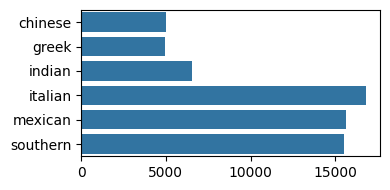

In [129]:
fig, ax = plt.subplots(figsize=(4, 2))
sns.barplot(x=y.sum(axis=0), y=labels_encoder.get_feature_names_out(), ax=ax)
plt.tight_layout()
plt.show()

In [130]:
labels = labels_encoder.get_feature_names_out()
y_true = [labels[int(np.where(a == 1)[0][0])] for a in y]
y_true[:5]

['italian', 'italian', 'italian', 'mexican', 'mexican']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, train_size=.7)

## Classic classifiers

In [132]:
from bornrule import BornClassifier

In [133]:
born = BornClassifier()
born.fit(X_train, y_train)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


BornClassifier()

In [134]:
y_pred = born.predict(X_test)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Evaluation

In [135]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [136]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     chinese       0.71      0.92      0.80      1489
       greek       0.52      0.81      0.63      1379
      indian       0.79      0.89      0.83      1967
     italian       0.87      0.77      0.82      5141
     mexican       0.85      0.85      0.85      4727
    southern       0.79      0.64      0.71      4627

    accuracy                           0.79     19330
   macro avg       0.75      0.81      0.77     19330
weighted avg       0.80      0.79      0.79     19330



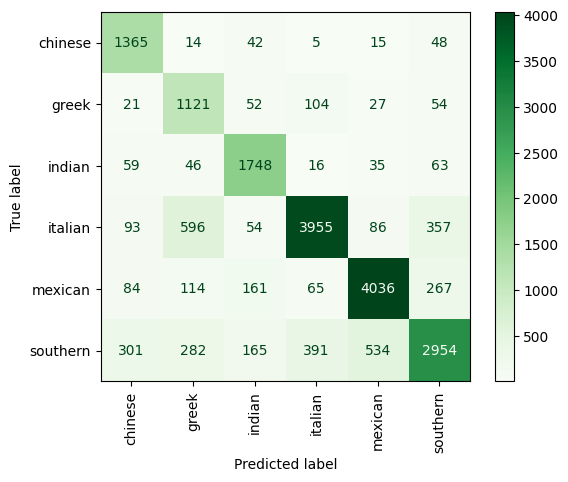

In [137]:
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation='vertical')
plt.show()

## Explainability

### Local explanation

In [138]:
test_recipe = ['garlic', 'mozzarella cheese', 'onions', 'pasta', 'diced tomatoes', 'olive oil']
vector = ingredients_encoder.transform(["|".join(test_recipe)]).toarray()
born.predict(vector)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


array(['italian'], dtype='<U8')

In [139]:
local_explain = pd.DataFrame(born.explain(vector), index=ingredients_encoder.get_feature_names_out(), columns=labels)
local_explain.head()

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


,chinese,greek,indian,italian,mexican,southern
,0.0,0.0,0.0,0.0,0.0,0.0
1%25 fat cottage cheese,0.0,0.0,0.0,0.0,0.0,0.0
1%25 low-fat milk,0.0,0.0,0.0,0.0,0.0,0.0
10-inch flour tortillas,0.0,0.0,0.0,0.0,0.0,0.0
2%25 cheddar cheese,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
local_explain['italian'].sort_values(ascending=False).head(10)

mozzarella cheese    0.024280
olive oil            0.015475
pasta                0.010976
diced tomatoes       0.003069
onions               0.001672
garlic               0.000715
                     0.000000
parmigiano           0.000000
pappardelle pasta    0.000000
paprika              0.000000
Name: italian, dtype: float64

### Global explanation

In [141]:
global_explain = pd.DataFrame(born.explain(X_test), index=ingredients_encoder.get_feature_names_out(), columns=labels)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [142]:
global_explain.head()

,chinese,greek,indian,italian,mexican,southern
,0.002486,0.003042,0.007091,0.003028,0.004107,0.002802
1%25 fat cottage cheese,0.000000,0.001854,0.000000,0.001462,0.000889,0.000000
1%25 low-fat milk,0.001161,0.000486,0.001321,0.001678,0.001327,0.001224
10-inch flour tortillas,0.000000,0.000000,0.000000,0.000000,0.011505,0.002043
2%25 cheddar cheese,0.000000,0.000000,0.000000,0.003024,0.007508,0.000000


In [148]:
global_explain.sort_values(by='chinese', ascending=False).head(10)

,chinese,greek,indian,italian,mexican,southern
soy sauce,1.519908,0.157757,0.201502,0.124259,0.193612,0.310168
sesame oil,0.836478,0.047501,0.117150,0.041127,0.054264,0.092374
cornstarch,0.730009,0.143949,0.138831,0.154466,0.137410,0.236364
fresh ginger,0.415945,0.032470,0.338478,0.037476,0.047008,0.073415
ginger,0.361971,0.025024,0.330228,0.026640,0.046850,0.076432
peanut oil,0.337618,0.046724,0.101704,0.031494,0.043973,0.092032
hoisin sauce,0.327667,0.000000,0.019621,0.009496,0.017209,0.031642
oyster sauce,0.292359,0.016707,0.019968,0.000000,0.016749,0.018850
light soy sauce,0.266724,0.000000,0.017920,0.011501,0.023412,0.018043
olive oil,0.243335,0.869882,0.343179,0.749109,0.444405,0.355212
